In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
from astropy.stats import LombScargle

plt.style.use('seaborn-whitegrid')

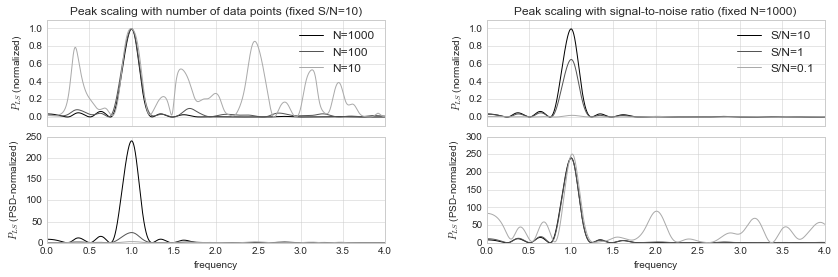

In [2]:
def create_data(N, T=4, signal_to_noise=5, period=1.0, random_state=None):
    rng = np.random.RandomState(random_state)
    t = T * rng.rand(N)
    dy = 0.5 / signal_to_noise * np.ones_like(t)
    y = np.sin(2 * np.pi * t / period) + dy * rng.randn(N)
    return t, y, dy


fig, ax = plt.subplots(2, 2, figsize=(12, 4), sharex='col')
fig.subplots_adjust(hspace=0.1, wspace=0.3, left=0.05, right=0.95)

for axi in ax.flat:
    axi.set_prop_cycle(cycler('color', ['#000000', '#555555', '#AAAAAA']))

for N in [1000, 100, 10]:
    t, y, dy = create_data(N, signal_to_noise=10, random_state=68345)
    ls = LombScargle(t, y, dy)
    freq = np.linspace(0.01, 4, 2000)
    power = ls.power(freq, normalization='standard', assume_regular_frequency=True)
    ax[0, 0].plot(freq, power, label='N={0}'.format(N))
    power = ls.power(freq, normalization='psd', assume_regular_frequency=True)
    ax[1, 0].plot(freq, power, label='N={0}'.format(N))
ax[0, 0].legend()
    
for SN in [10, 1, 0.1]:
    t, y, dy = create_data(1000, signal_to_noise=SN, random_state=68345)
    ls = LombScargle(t, y, dy)
    freq = np.linspace(0.01, 4, 2000)
    power = ls.power(freq, normalization='standard', assume_regular_frequency=True)
    ax[0, 1].plot(freq, power, label='S/N={0}'.format(SN))
    power = ls.power(freq, normalization='psd', assume_regular_frequency=True)
    ax[1, 1].plot(freq, power, label='S/N={0}'.format(SN))
ax[0, 1].legend()

ax[0, 0].set(ylim=(-0.1, 1.1),
             ylabel='$P_{LS}$ (normalized)',
             title='Peak scaling with number of data points (fixed S/N=10)')
ax[0, 1].set(ylim=(-0.1, 1.1),
             ylabel='$P_{LS}$ (normalized)',
             title='Peak scaling with signal-to-noise ratio (fixed N=1000)')


ax[1, 0].set(xlabel='frequency',
             ylabel='$P_{LS}$ (PSD-normalized)')
ax[1, 1].set(xlabel='frequency',
             ylabel='$P_{LS}$ (PSD-normalized)')
ax[1, 0].set(xlabel='frequency',
             ylabel='$P_{LS}$ (PSD-normalized)')
ax[1, 1].set(xlabel='frequency',
             ylabel='$P_{LS}$ (PSD-normalized)')

fig.savefig('fig26_peak_width_height.pdf')

## Bootstrap Stuff

In [3]:
def LombScargle_bootstrap(t, y, dy, freq, n_bootstraps=100,
                          aggregate=max, random_seed=None,
                          normalization='standard'):
    rng = np.random.RandomState(random_seed)
    
    def bootstrapped_power():
        resample = rng.randint(0, len(y), len(y))  # sample with replacement
        ls_boot = LombScargle(t, y[resample], dy[resample])
        return aggregate(ls_boot.power(freq, normalization=normalization))
    
    return np.array([bootstrapped_power() for i in range(n_bootstraps)])

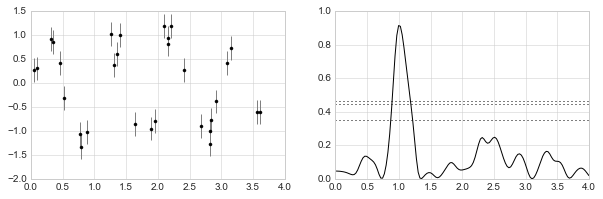

In [4]:
t, y, dy = create_data(30, signal_to_noise=2, random_state=583)
ls = LombScargle(t, y, dy)
freq, power = ls.autopower(maximum_frequency=4, samples_per_peak=10)

p_boot = LombScargle_bootstrap(t, y, dy, freq)

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].errorbar(t, y, dy, fmt='.k', ecolor='gray', capsize=0)

ax[1].plot(freq, power, '-k')
for cutoff in np.percentile(p_boot, [85, 95, 99]):
    ax[1].axhline(cutoff, color='black', linestyle='dotted')